<a href="https://colab.research.google.com/github/edwinchenyj/scientific-computing-notes/blob/main/stiff_ode/python/stiff_ode_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Introduction to Stiff ODEs in Python

**Notice:** In my previous [post on stiff ODEs](https://edwinchenyj.github.io/scientific%20computing/stiff/), I demonstrated how different ODE solvers in Matlab perform with a few examples. The [live script](https://github.com/edwinchenyj/scientific-computing-notes/tree/main/stiff_ode) for the post is also provided for educational purpose. In this post, I will do the same in Python. You can find the `ipynb` file in the same [repository](https://github.com/edwinchenyj/scientific-computing-notes/tree/main/stiff_ode).


The solver interfaces provided by Matlab and SciPy are not exactly the same (SciPy uses `rtol*abs(y)+atol` while Matlab uses `max(rtol*abs(y),atol)`), so we will use different solvers and tolerances. . If you are interested, please refered to the [SciPy document](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) and the [Matlab document](https://www.mathworks.com/help/matlab/ref/odeset.html)

---

It’s well-known that stiff ODEs are hard to solve. Many books are written on this topic, and SciPy even provides solvers specialized for stiff ODEs. It is easy to find resources, including the wikipedia entry, with technical and detailed explanations. For example, one of the common descriptions for stiff ODEs may read:

*An ODE is stiff if absolute stability requirement is much more restrictive than accuracy requirement, and we need to be careful when we choose our ODE solver.*

However, it’s fairly abstract and hard to understand for people new to scientific computing. In this post, I hope to make the concept of stiffness in ODEs easier to understand by showing a few examples. Let’s start with a simple (non-stiff) example, and compare it with some stiff examples later on.

## Example 1

Let's consider a non-stiff ODE


$y'=Ay$



where $A=\lambda$



In the first case we have $\lambda=-0.1$. The solution is 



$y(t)=e^{-0.1t}y(0)$,




meaning we have a exponential decaying function.

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, RK45
import matplotlib.pyplot as plt

mlambda = -1e-1
A = np.matrix([mlambda])

F = lambda t,u: A.dot(u.flatten())

# initial condition
u0 = np.ones(A.shape[0])

# time points
t = [0,10]

### RK45
We can look at the solution from `RK45:`

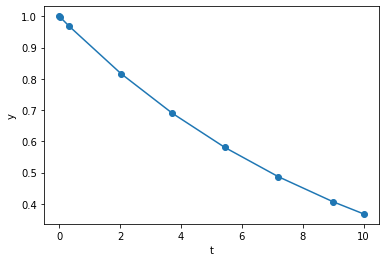

In [3]:
# solve ODE
sol = solve_ivp(F,t,u0,'RK45',rtol=1e-7,atol=1e-7)

# # # # plot results
plt.plot(sol.t,sol.y[0], 'o-')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

As we can see, it `RK45` gives us a decaying function. In this interval, `RK45` used

In [4]:
sol.t.size

9

steps to achieve the specified tolerance.

## Example 2

Let's consider the same equation


$y'=Ay$



but now $A=\begin{bmatrix}\lambda_1 & \\ & \lambda_2\end{bmatrix}$



In the first case we have $\lambda_1=-0.1,\ \lambda_2=10^3\lambda_1$. This means we have two decoupled equations. The solution is 


$y(t)=\begin{bmatrix}y_1(t)\\y_2(t)\end{bmatrix}=\begin{bmatrix}e^{-0.1t}y_1(0)\\e^{-100t}y_2(0)\end{bmatrix}$,
meaning we have two exponential decaying functions.


In [5]:
mlambda1 = -1e-1
mlambda2 = 1e3*mlambda1
A = np.diag([mlambda1, mlambda2])

F = lambda t,u: A.dot(u) 


# initial condition
u0 = np.ones(A.shape[0])

# time points
t = [0,10]

### RK45
We can use `RK45` to solve it in the same fashion:

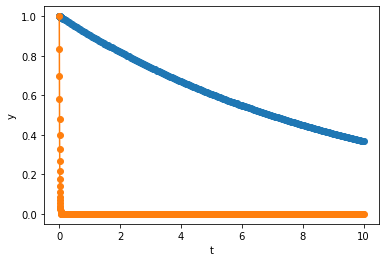

In [6]:
# solve ODE
sol = solve_ivp(F,t,u0,'RK45',rtol=1e-7,atol=1e-7)

# # plot results
plt.plot(sol.t,sol.y[0],'o-',sol.t,sol.y[1],'o-')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

This time we get 2 decaying functions, and $y_2$ decays much faster then $y_1$. In this same interval, `RK45` used 

In [7]:
sol.t.size

333

steps to achieve the desired error tolerance. In this example, $y_1$ is exactly the same as the solution in Example 1, but it take much longer to calculate. One may think the step size of `RK45` is limited by the *accuracy requirement* due to the addition of $y_2$. However, this is clearly not the case since $y_2$ is almost identically $0$ on the entire interval. What is happening here is that, the step size of `RK45` is limited by the *stability requirement* of $y_2$, and we call the ODE in Example 2 ***stiff***.




SciPy provides specialized ODE solvers for stiff ODEs. Let's look at `BDF` and `Radau`

### BDF

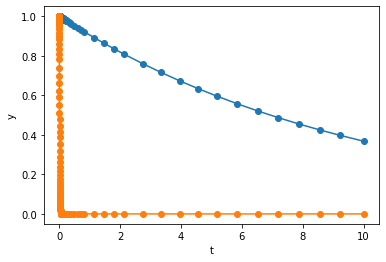

In [8]:
# solve ODE
sol = solve_ivp(F,t,u0,'BDF',rtol=1e-7,atol=1e-7)

# # plot results
plt.plot(sol.t,sol.y[0],'o-',sol.t,sol.y[1],'o-')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

`BDF` takes 

In [9]:
sol.t.size

134

### Radau

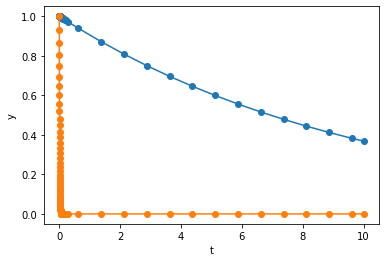

In [10]:
# solve ODE
sol = solve_ivp(F,t,u0,'Radau',rtol=1e-7,atol=1e-7)

# # plot results
plt.plot(sol.t,sol.y[0],'o-',sol.t,sol.y[1],'o-')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

and `Radau` takes

In [11]:
sol.t.size

85

steps. Apparently, `BDF` and `Radau` is significantly more efficient than `RK45` for this example. From the figure above, we can also see that `BDF` and `Radau` stratigically used shorter step size when $y_2$ is decaying fast, and larger step size when $y_2$ flattens out.

At this point you may think that if you don't know whether an ODE is stiff or not, it is always better to use `BDF` and `Radau`. However, this is not the case, as we will show in the next example.

# Ocsillatory ODE

## Example 3


Let's look at an oscillatory ODE


$y'=Ly$



and $L=\begin{bmatrix} & \lambda\\-\lambda & \end{bmatrix},\ \lambda=-0.1$

The eigenpairs of $L$
 are


$(\pm\lambda i,\;\begin{bmatrix}1 \\ \pm i\end{bmatrix})$



The solution is oscillatory because the eigenvalues are imaginary.

In [ ]:
mlambda = -1e-1
L = np.matrix([[ 0, mlambda],[ -mlambda, 0]])

F = lambda t,u: L.dot(u.flatten())


# initial condition
u0 = np.ones(L.shape[0])

# time points
t = [0,50]

### RK45
Let's look at the solution from `RK45`

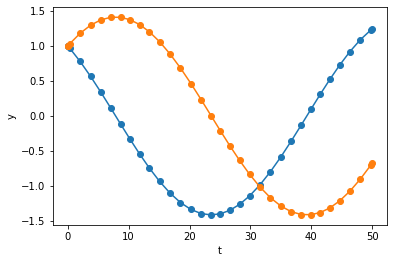

In [ ]:
# solve ODE
sol = solve_ivp(F,t,u0,'RK45',rtol=1e-7,atol=1e-7)

# # plot results
plt.plot(sol.t,sol.y[0],'o-',sol.t,sol.y[1],'o-')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

In [ ]:
sol.t.size

34


As expected, we see two slow oscillatory functions.


## Example 4


Now let's look at a stiff oscillatory ODE


$y'=Ly$



and $L=\begin{bmatrix}& A\\ -A &\end{bmatrix},\: A=\begin{bmatrix}\lambda_1 & \\ & \lambda_2\end{bmatrix}$


The eigenpairs of $L$
are $\begin{pmatrix}\pm \lambda_1i, \begin{bmatrix}1 \\ 0 \\ \pm i \\ 0\end{bmatrix}\end{pmatrix}$ and $\begin{pmatrix}\pm \lambda_2i, \begin{bmatrix}0 \\ 1 \\ 0 \\ \pm i\end{bmatrix}\end{pmatrix}$



Similar to before, we set $\lambda_1=0.1, \lambda_2=100\lambda_1$. Now we have both fast and slow oscillatory functions in our solution.




In [ ]:
mlambda1 = -1e-1
mlambda2 = 1e2*mlambda1
A = np.diag([mlambda1, mlambda2])
L = np.block([[np.zeros([2,2]),A],[-A,np.zeros([2,2])]])

F = lambda t,u: L.dot(u.flatten()) 


# initial condition
u0 = np.ones(L.shape[0])


# time points
t = [0,50]

### RK45

Text(0, 0.5, 'y')

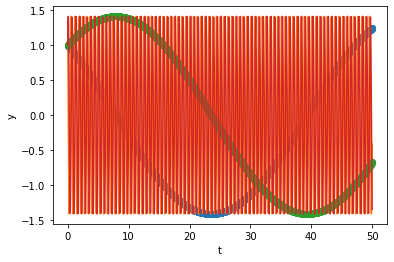

In [ ]:
# solve ODE
sol = solve_ivp(F,t,u0,'RK45',rtol = 1e-6, atol = 1e-6)

# # plot results
plt.plot(sol.t,sol.y[0],'o-',sol.t,sol.y[1],'-',sol.t,sol.y[2],'o-',sol.t,sol.y[3],'-')
plt.xlabel('t')
plt.ylabel('y')

In the plots we can see both slow and highly oscillatory parts. Again, similar to the decaying case, now `RK45` is taking shorter step sizes because of the the fast oscillating part, even though  and  could have taken much shorter time steps like the example above. In this case,

In [ ]:
sol.t.size

1772

This time `BDF` and `Radau` are not that efficient either.

### BDF

Text(0, 0.5, 'y')

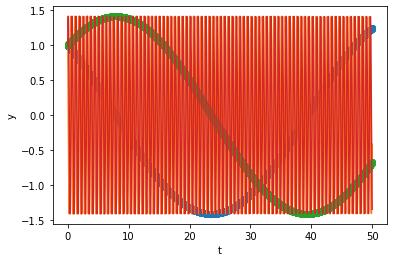

In [ ]:
# solve ODE
sol = solve_ivp(F,t,u0,'BDF',rtol = 1e-6, atol = 1e-6)

# # plot results
plt.plot(sol.t,sol.y[0],'o-',sol.t,sol.y[1],'-',sol.t,sol.y[2],'o-',sol.t,sol.y[3],'-')
plt.xlabel('t')
plt.ylabel('y')

In [ ]:
sol.t.size

3853

### Radau

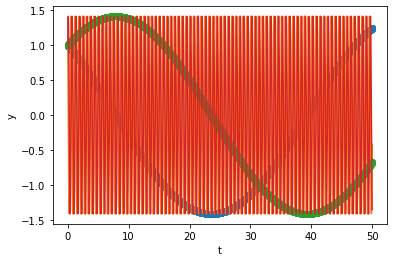

In [ ]:
# solve ODE
sol = solve_ivp(F,t,u0,'Radau',rtol = 1e-6, atol = 1e-6)

# # plot results
plt.plot(sol.t,sol.y[0],'o-',sol.t,sol.y[1],'-',sol.t,sol.y[2],'o-',sol.t,sol.y[3],'-')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

In [ ]:
sol.t.size

3788

Notice highly oscillatory and stiff ODEs are generally hard to solve. All the solvers, `RK45`, `BDF`, and `Radau` take very short steps and become very expensive. 

**Info:** You may feel the examples here are quite artificial since they are all linear and the analytical solutions are available. However, I feel it's pedagogical to introduce stiffness in a simple setting like this. There will be a future post demonstrating stiff ODEs in nonlinear cases.

This blog post is published at [https://edwinchenyj.github.io.](https://edwinchenyj.github.io.) The pdf version and the source code are available at [https://github.com/edwinchenyj/scientific-computing-notes](https://github.com/edwinchenyj/scientific-computing-notes).